# Get top 10 momentum stocks
# Get RSI of momentum stocks

## import libraries

In [1]:
import bs4 as bs
import datetime as dt
import os
import pickle
import requests

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import seaborn as sns
from scipy.stats import norm
%matplotlib inline

## download stock data from yahoo finance for past 3 months

In [2]:
def save_sp500_tickers():
    resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    soup = bs.BeautifulSoup(resp.text, 'lxml')
    table = soup.find('table', {'class': 'wikitable sortable'})
    tickers = []
    for row in table.findAll('tr')[1:]:
        ticker = row.findAll('td')[0].text
        tickers.append(ticker)
    with open("sp500tickers.pickle", "wb") as f:
        pickle.dump(tickers, f)
    return tickers

stocks_list = save_sp500_tickers()
stocks_list = [ticker[:-1] for ticker in stocks_list] # remove '\n' from tickers in tickers list

In [3]:
no_days = 180
today = datetime.now()
begin = (today - timedelta(days=no_days)).strftime('%Y-%m-%d')
stocks = yf.download(stocks_list, start=begin)['Adj Close']
stocks

[*********************100%***********************]  503 of 503 completed

2 Failed downloads:
- BF.B: No data found for this date range, symbol may be delisted
- BRK.B: No timezone found, symbol may be delisted


,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,ADBE,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2023-01-30,151.204468,15.960000,147.504135,142.584778,142.739883,164.330521,108.742424,63.990002,272.258881,363.420013,...,99.134758,67.001236,111.723373,36.265682,100.452705,127.852150,125.381844,309.029999,50.929619,163.986389
2023-01-31,151.543274,16.139999,149.866089,143.871017,144.797928,167.958893,109.475243,64.349998,276.953339,370.339996,...,103.405052,67.660423,114.133759,36.563519,103.344070,129.308609,126.886467,316.179993,51.836464,164.772964
2023-02-01,154.901367,16.690001,154.353806,145.007706,143.670914,160.095749,110.732887,64.180000,281.469177,383.920013,...,104.083511,68.486870,112.884293,37.208809,104.248245,127.822426,127.344833,328.630005,52.060738,167.082916
2023-02-02,154.951187,17.059999,152.779175,150.382080,141.946060,157.531036,111.158714,61.349998,291.890259,392.230011,...,102.726593,68.437675,109.352356,39.373035,105.251778,127.029808,126.956215,344.700012,52.938332,170.259094
2023-02-03,154.004547,17.020000,149.757828,154.051376,142.298874,155.801346,110.703178,61.259998,287.046936,379.329987,...,102.726593,66.883179,110.109894,38.161861,104.576134,125.840851,128.988937,330.809998,53.055340,167.072968
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-21,127.620003,17.420000,70.730003,191.940002,143.740005,192.589996,114.290001,82.269997,314.799988,520.229980,...,107.180000,65.209999,103.889999,40.759998,113.769997,137.539993,142.229996,306.459991,36.110001,183.509995
2023-07-24,127.720001,16.879999,72.760002,192.750000,143.179993,191.449997,114.620003,81.190002,313.290009,523.859985,...,107.510002,65.080002,105.519997,40.459999,113.959999,137.940002,140.869995,302.589996,37.049999,185.580002
2023-07-25,127.309998,16.650000,71.550003,193.619995,141.630005,191.889999,112.930000,81.360001,317.589996,525.340027,...,108.839996,64.959999,105.680000,40.570000,114.349998,136.990005,140.300003,301.429993,35.779999,190.149994


## calculate returns for past 180 days

In [4]:
# get stock data for past n days
def get_range_stocks(stocks, range_days): 
    range_start = (today - timedelta(days=range_days)).strftime('%Y-%m-%d')
    range_stocks = stocks[stocks.index >= datetime.strptime(range_start, '%Y-%m-%d')]
    return range_stocks

range_stocks = get_range_stocks(stocks, no_days)

In [5]:
def get_summary(stocks_df):
    stocks_daily_ret = stocks.pct_change()
    stocks_daily_ret = stocks_daily_ret.iloc[1:]
    stocks_range_summary = stocks_daily_ret.describe().T.loc[:,['mean', 'std']] * len(stocks_df)
    stocks_range_summary['std'] = stocks_range_summary['std']*np.sqrt(len(stocks_df))
    return stocks_range_summary

range_stocks_summary = get_summary(range_stocks)
range_stocks_summary

,mean,std
A,-0.145073,21.683328
AAL,0.073645,30.980532
AAP,-0.593112,51.233481
AAPL,0.322640,16.980776
ABBV,0.058672,19.628071
...,...,...
YUM,0.080633,14.377129
ZBH,0.126385,15.711101
ZBRA,0.021374,31.353316
ZION,-0.117428,68.460449


## get top 10 stocks with highest return

In [6]:
momentum_10 = range_stocks_summary.sort_values(by='mean', ascending=False)
momentum_10 = momentum_10.head(10)
momentum_10

,mean,std
NVDA,0.943063,47.850196
META,0.768527,41.992826
RCL,0.614100,34.238232
CCL,0.581483,47.066595
PHM,0.531514,25.458745
TSLA,0.530660,44.638692
AMD,0.519317,43.433041
PANW,0.491578,31.772261
ALGN,0.488942,53.031641
AVGO,0.482251,27.683805


## plot return vs risk

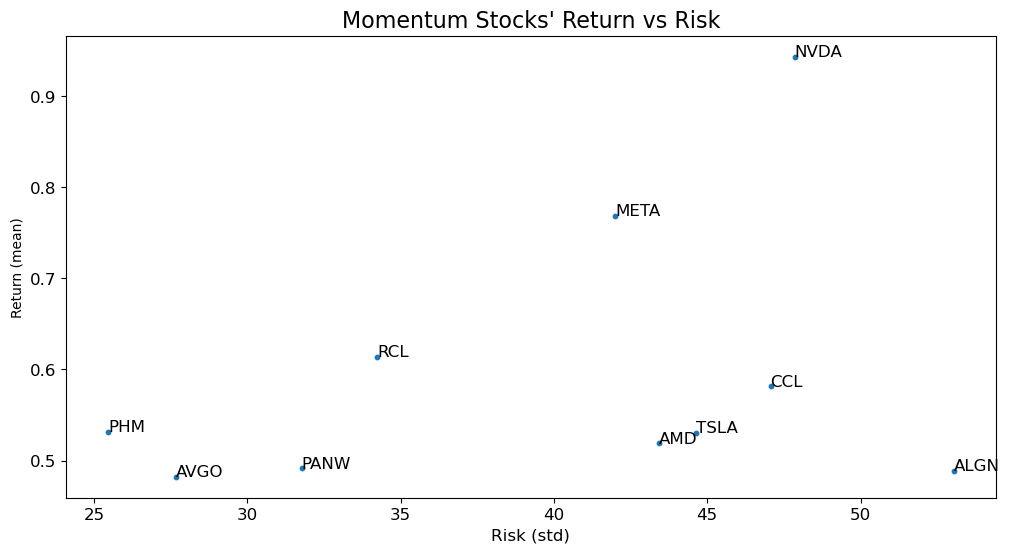

In [7]:
momentum_10.plot.scatter(x='std', y='mean', figsize=(12,6), s=10, fontsize=12)
for i in momentum_10.index:
    plt.annotate(i, xy=(momentum_10.loc[i, 'std'], momentum_10.loc[i, 'mean']), size=12)
plt.xlabel('Risk (std)', fontsize=12)
plt.ylabel('Return (mean)')
plt.title('Momentum Stocks\' Return vs Risk', fontsize=16)
plt.show()

## calculate Relative Strength Index (RSI) of stocks

In [8]:
change = range_stocks.diff()

In [58]:
# Create two copies of the Closing price Series
change_up = change.copy()
change_down = change.copy()

change_up[change_up<0] = 0
change_down[change_down>0] = 0

# Calculate the rolling average of average up and average down
rsi_timeframe = 14
avg_up = change_up.rolling(rsi_timeframe).mean()
avg_down = change_down.rolling(rsi_timeframe).mean().abs()

# Calculate rsi
rsi = 100 * avg_up / (avg_up + avg_down)
rsi.dropna(how='all', inplace=True)
rsi

,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,ADBE,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2023-02-17,41.291247,56.802745,50.251958,66.440033,63.286397,45.066767,37.903884,66.050396,52.315508,46.549003,...,84.341668,49.510342,47.123081,46.660224,68.610965,60.791437,50.475550,56.101947,47.163516,59.178566
2023-02-21,32.312017,43.440227,33.967486,56.786669,60.683759,37.572253,27.061120,63.559338,42.031547,37.990256,...,65.090288,41.586247,41.107681,43.170950,48.818714,52.644362,38.998684,46.157713,30.741906,55.262508
2023-02-22,20.222674,31.229194,18.879437,55.823663,60.139500,49.091732,19.008817,65.640602,37.967222,29.737498,...,64.603317,33.777726,40.778124,38.392867,45.280559,53.426120,36.158944,39.114895,26.874434,48.373407
2023-02-23,23.851957,29.830475,18.870553,47.787108,68.341014,53.533879,16.412684,86.500523,26.734512,21.831762,...,62.060273,32.653027,51.104573,22.180469,42.827844,54.076121,36.015841,27.460279,18.025753,48.226953
2023-02-24,22.832639,27.329154,18.790977,35.419231,68.784451,55.619113,14.747925,88.286551,26.832765,18.672064,...,60.489815,36.848373,49.174735,23.137279,42.215244,51.489341,25.165641,28.893957,26.295558,48.261171
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-21,69.886671,43.809519,52.620999,44.216534,75.951291,50.581408,69.752555,83.065987,59.745258,68.091269,...,53.123754,69.047617,40.529869,56.630812,54.187884,46.666633,37.244479,57.941144,78.637775,71.654353
2023-07-24,73.728812,36.681215,57.193175,50.860513,73.550291,51.979082,79.978261,81.468608,54.684281,72.421398,...,51.820039,64.383579,44.937360,57.875476,58.111178,52.347575,42.857143,54.491198,78.178372,79.054595
2023-07-25,71.779125,31.808286,52.092848,56.901723,64.182164,54.572287,70.603453,84.430649,61.013122,72.237806,...,66.953599,58.850212,46.723485,67.283979,67.338343,51.129370,41.344544,56.299555,73.136097,84.424759


## get yesterday's RSI of momentum stocks

In [59]:
momentum_10_tickers = list(momentum_10.index)
momentum_rsi_list = []
momentum_rsi_dict = {}
for ticker in momentum_10_tickers:
    ticker_rsi = rsi[ticker][-2]
    momentum_rsi_list.append(rsi[ticker][-2])
    momentum_rsi_dict[ticker] = ticker_rsi

momentum_rsi_dict

{'NVDA': 64.14870294531282,
 'META': 54.88276243143969,
 'RCL': 46.84173306967063,
 'CCL': 37.875731740179916,
 'PHM': 73.32997400029507,
 'TSLA': 42.158757279967716,
 'AMD': 43.050418115099035,
 'PANW': 42.571275477820166,
 'ALGN': 54.36674719133652,
 'AVGO': 65.55152546012205}